In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from urllib.parse import unquote
import numpy as np
import os
import pprint
import random
import math

import networkx as nx

### Reading data frames into dictionary

In [77]:
def reading_filenames(input_dir):
    files = [f for f in os.listdir(input_dir) if f.endswith('.tsv') or f.endswith('.txt')]

    return files

In [78]:
data_folder = 'data/wikispeedia_paths-and-graph/'
file_names = reading_filenames(data_folder)

In [79]:
dataframes = {}

#Reading files in dictionary
for file in file_names:
    try:
        if file.endswith('.tsv'):
            df = pd.read_csv(data_folder + file, sep='\t', comment='#', header = None, encoding="utf-8")
        else:
            df = pd.read_csv(data_folder + file, sep=',', comment='#', header = None, encoding="utf-8")
        
        dataframes[file.split('.')[0]] = df
    except pd.errors.ParserError as e:
        print(f"Could not parse {file}: {e}")

In [80]:
dataframes['links'] = dataframes['links'].rename(columns={0: "linkSource", 1: "linkTarget"})

In [81]:
dataframes["links"]["linkSource"] = dataframes["links"]["linkSource"].apply(unquote)
dataframes["links"]["linkTarget"] = dataframes["links"]["linkTarget"].apply(unquote)

In [82]:
dataframes['links'].head(10)

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
5,Áedán_mac_Gabráin,Isle_of_Man
6,Áedán_mac_Gabráin,Monarchy
7,Áedán_mac_Gabráin,Orkney
8,Áedán_mac_Gabráin,Picts
9,Áedán_mac_Gabráin,Scotland


In [83]:
#Renaming columns
dataframes['categories'] = dataframes['categories'].rename(columns={0: "article", 1: "category"})

In [84]:
#Decoding article names
dataframes["categories"]["article"] = dataframes["categories"]["article"].apply(unquote)

In [85]:
#Splitting categories into sub categories
split_columns = dataframes["categories"]['category'].str.split('.', expand=True)

#Dropping first column which only contains the word subject
split_columns = split_columns.drop(0, axis=1)
split_columns.head()


,1,2,3
0,History,British_History,British_History_1500_and_before_including_Roma...
1,People,Historical_figures,None
2,Countries,None,None
3,Geography,European_Geography,European_Countries
4,People,Artists,None


In [86]:
#Joining with original dataframe
dataframes["categories"] = dataframes["categories"].join(split_columns)

In [87]:
dataframes['articles'] = dataframes['articles'].rename(columns={0: "article"})
dataframes["articles"]["article"] = dataframes["articles"]["article"].apply(unquote)

In [88]:
dataframes['articles'].head(10)


,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts
5,€2_commemorative_coins
6,10th_century
7,11th_century
8,12th_century
9,13th_century


### Create network

In [89]:
G = nx.from_pandas_edgelist(dataframes["links"], source='linkSource', target='linkTarget')

In [90]:
dataframes["categories"]

,article,category,1,2,3
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán_mac_Gabráin,subject.People.Historical_figures,People,Historical_figures,None
2,Åland,subject.Countries,Countries,None,None
3,Åland,subject.Geography.European_Geography.European_...,Geography,European_Geography,European_Countries
4,Édouard_Manet,subject.People.Artists,People,Artists,None
...,...,...,...,...,...
5199,Zirconium,subject.Science.Chemistry.Chemical_elements,Science,Chemistry,Chemical_elements
5200,Zoroaster,subject.People.Religious_figures_and_leaders,People,Religious_figures_and_leaders,None
5201,Zuid-Gelders,subject.Geography.European_Geography,Geography,European_Geography,None
5202,Zuid-Gelders,subject.Language_and_literature.Languages,Language_and_literature,Languages,None


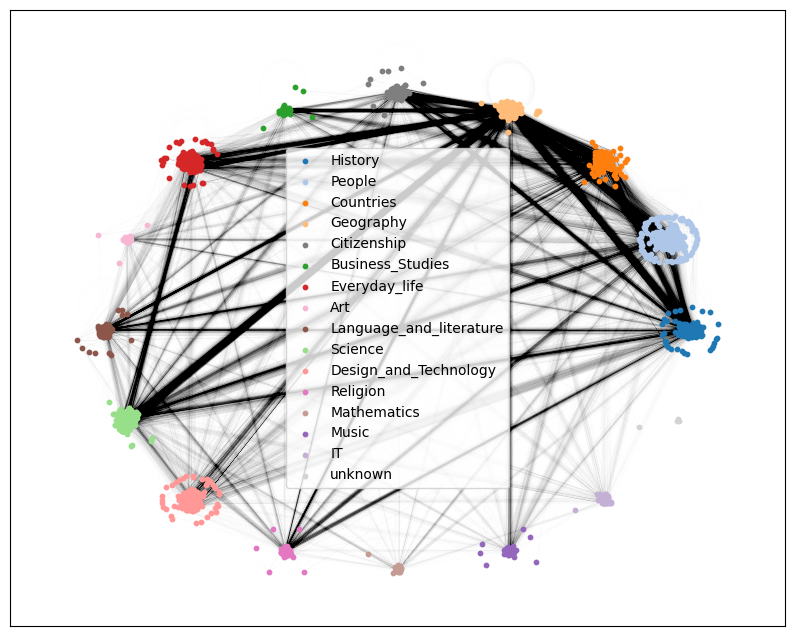

In [189]:
#Note: Make so that articles with several subjects have a special color??
color_map = {category: color for category, color in zip(dataframes["categories"][1].unique(), plt.cm.tab20.colors)}

for node in G.nodes:

    result = dataframes['categories'][dataframes['categories']['article'] == node][1]

    if not result.empty:
        category = result.values[0]  # Get the first category value
        G.nodes[node]['color'] = color_map.get(category, "grey")
        G.nodes[node]['category'] = category
    else:   
        G.nodes[node]['color'] = "lightgrey"
        G.nodes[node]['category'] = "unknown"


# Cluster nodes based on category
clusters = {}
for node, data in G.nodes(data=True):
    category = data['category']
    if category not in clusters:
        clusters[category] = []
    clusters[category].append(node)


positions = {}
r = 10 

# Places all clusters in a circle
for index, (category, nodes) in enumerate(clusters.items()):
    # Creates a subgraph for each category and positions them using spring_layput
    subG = G.subgraph(nodes)
    sub_positions = nx.spring_layout(subG, seed=1, k=0.1)

    # Displaces all nodes in subG on a circle around the origin
    angle = (2 * math.pi * index) / len(clusters)
    x = r * math.cos(angle)
    y = r * math.sin(angle)

    for node in sub_positions:
        positions[node] = [sub_positions[node][0] + x, sub_positions[node][1] + y]
    
# Draws a plot clustered by category
plt.figure(figsize=(10, 8))

for category, nodes in clusters.items():
    nx.draw_networkx_nodes(G, pos=positions, 
                           node_size=10, 
                           nodelist=nodes, 
                           node_color=G.nodes[nodes[0]]['color'], 
                           label=category)
    
nx.draw_networkx_edges(G, positions, alpha=0.2, width=0.01)
plt.legend()
plt.show()


